In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import networkx as nx
import nxviz as nv
import re

In [2]:
data= pd.read_csv('dataset/emails.csv')
data_sample= data.sample(n = 500) 

In [3]:
pd.options.mode.chained_assignment = None
data_sample.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 500 entries, 67740 to 192687
Data columns (total 2 columns):
file       500 non-null object
message    500 non-null object
dtypes: object(2)
memory usage: 11.7+ KB


In [4]:
def get_text(Series, row_num_slicer):
    result = pd.Series(index=Series.index)
    for row, message in enumerate(Series):
        message_words = message.split('\n')
        del message_words[:row_num_slicer]
        result.iloc[row] = message_words
    return result

In [5]:
def get_row(Series, row_num):
    """returns a single row split out from each message. Row_num is the index of the specific
    row that you want the function to return."""
    result = pd.Series(index=Series.index)
    for row, message in enumerate(Series):
        message_words = message.split('\n')
        message_words = message_words[row_num]
        result.iloc[row] = message_words
    return result

In [6]:
def get_address(df, Series, num_cols=1):
    address = re.compile('[\w\.-]+@[\w\.-]+\.\w+')
    addresses = []
    result1 = pd.Series(index=df.index)
    result2 = pd.Series(index=df.index)
    result3 = pd.Series(index=df.index)
    for i in range(len(df)):
        for message in Series:
            correspondents = re.findall(address, message)
            addresses.append(correspondents)
            result1[i] = addresses[i][0]
        if num_cols >= 2:
            if len(addresses[i]) >= 3:
                result2[i] = addresses[i][1]
                if num_cols == 3:
                    if len(addresses[i]) >= 4:
                        result3[i] = addresses[i][2]
    return result1, result2, result3

In [7]:
def standard_format(df, Series, string, slicer):
    rows = []
    for row, message in enumerate(Series):
        message_words = message.split('\n')
        if string not in message_words[slicer]:
            rows.append(row)
    df = df.drop(df.index[rows])
    return df

In [8]:
x = len(data_sample.index)
headers = ['Message-ID: ', 'Date: ', 'From: ', 'To: ', 'Subject: ']
for i, v in enumerate(headers):
    data_sample = standard_format(data_sample, data_sample.message, v, i)
data_sample = data_sample.reset_index()
print("number of emails= {}; percent= {}%.".format(x - len(data_sample.index), np.round(((x - len(data_sample.index)) / x) * 100, decimals=2)))

number of emails= 119; percent= 23.8%.


In [9]:
data_sample['text'] = get_text(data_sample.message, 15)
data_sample['date'] = get_row(data_sample.message, 1)
data_sample['senders'] = get_row(data_sample.message, 2)
data_sample['recipients'] = get_row(data_sample.message, 3)
data_sample['subject'] = get_row(data_sample.message, 4)

data_sample.date = data_sample.date.str.replace('Date: ', '')
data_sample.date = pd.to_datetime(data_sample.date)

data_sample.subject = data_sample.subject.str.replace('Subject: ', '')

data_sample['recipient1'], data_sample['recipient2'], data_sample['recipient3'] = get_address(data_sample, data_sample.recipients, num_cols=3)
data_sample['sender'], x, y = get_address(data_sample, data_sample.senders)

del data_sample['recipients']
del data_sample['senders']
del data_sample['file']
del data_sample['message']

data_sample = data_sample[['date', 'sender', 'recipient1', 'recipient2', 'recipient3', 'subject', 'text']]

print(data_sample.head())

                 date                     sender                  recipient1  \
0 2001-06-23 04:46:00        jean.mrha@enron.com    louise.kitchen@enron.com   
1 2000-10-03 09:14:00         kay.mann@enron.com      gregg.penman@enron.com   
2 2001-10-26 17:40:29  amanda.rybarski@enron.com        mike.maggi@enron.com   
3 2001-01-12 09:53:00        eric.bass@enron.com  lwbthemarine@bigplanet.com   
4 2001-05-29 16:48:00    david.fairley@enron.com          kay.mann@enron.com   

                   recipient2  recipient3                         subject  \
0                         NaN         NaN             FW: Hot List Update   
1                         NaN         NaN  FW: Enovate/PEC ISDA Materials   
2                         NaN         NaN                             RE:   
3                         NaN         NaN   The US military gets mightier   
4  reagan.rorschach@enron.com         NaN               RE: Clarification   

                                                text  
0

/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


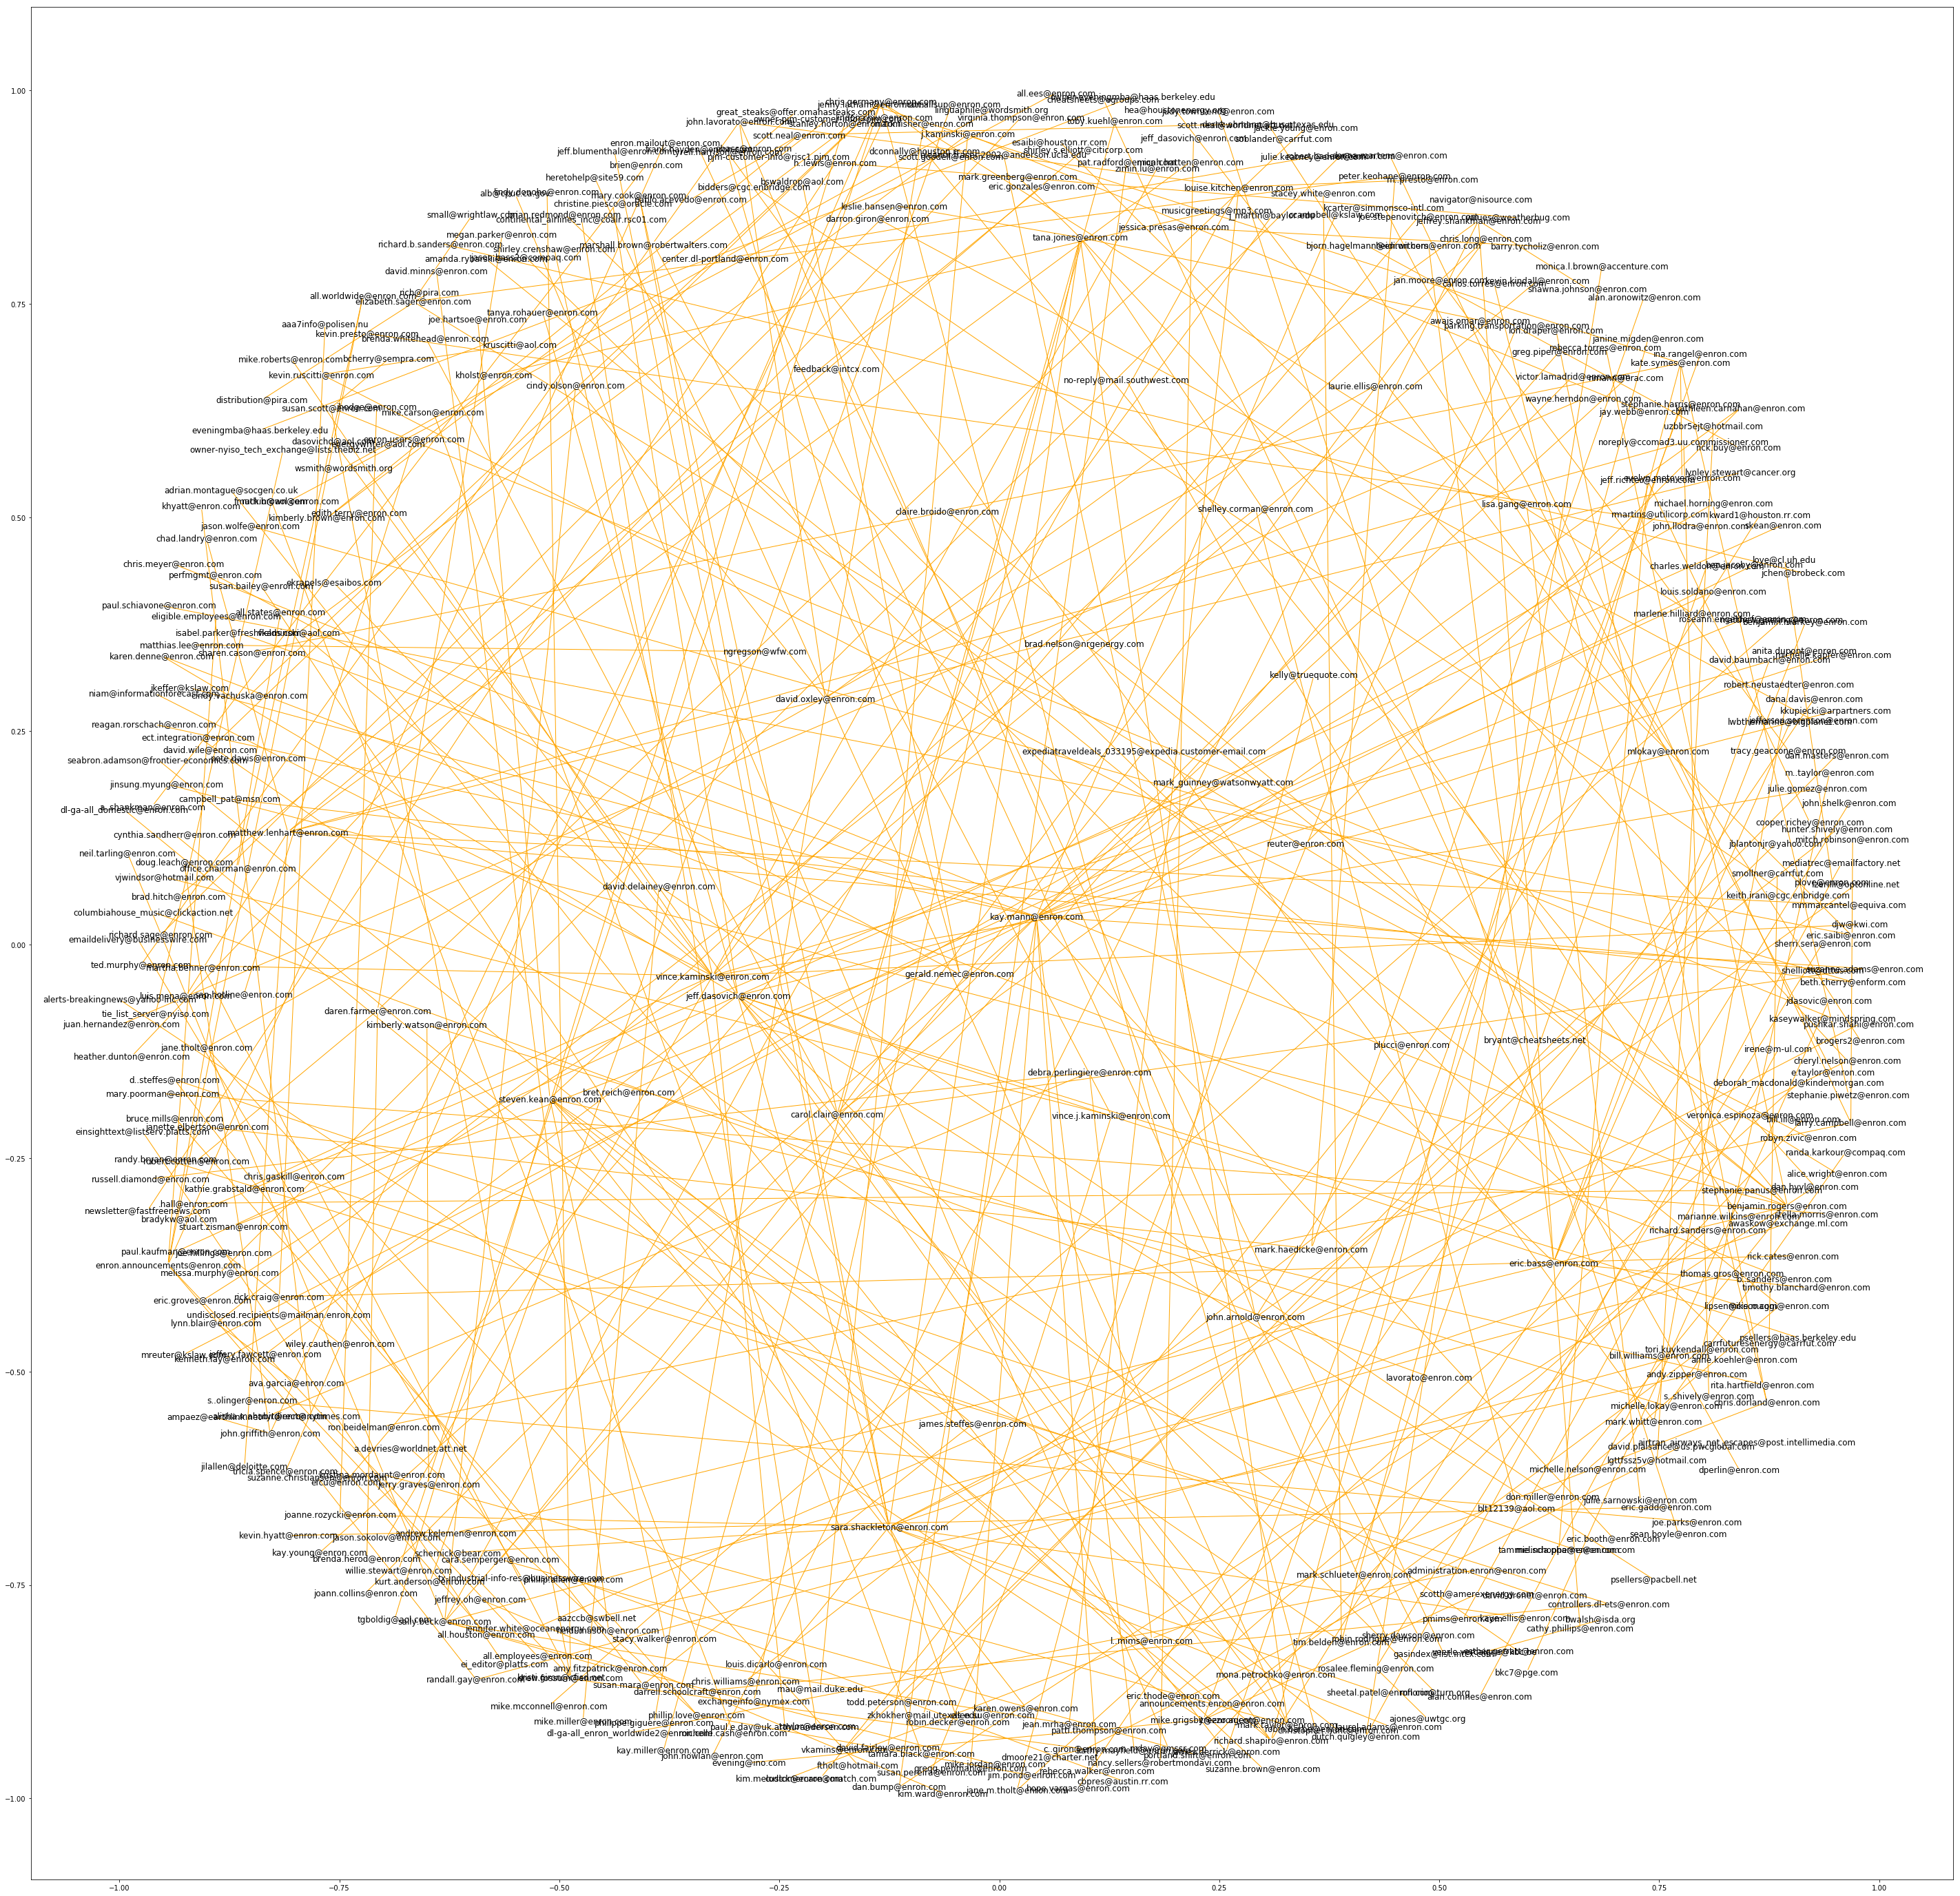

In [10]:
G = nx.from_pandas_edgelist(data_sample, 'sender', 'recipient1', edge_attr=['date', 'subject'])
plt.figure(figsize=(50,50))
pos = nx.spring_layout(G, k=1.0)
nx.draw_networkx(G, pos, node_size=50, node_color='white', with_labels=True, edge_color='orange')
plt.show()